In [2]:
import numpy as np

import torch
import torchvision
import torch.nn as nn
import torch.nn.functional as F

import matplotlib
import matplotlib.pyplot as plt
from matplotlib import image

import math

# Esercizio 1


Mostrare come sia possibile sostituire lo sfondo dell'immagine seguente analizzando soltanto l'istogramma

![](book.jpg)

(266, 400)


(array([4.590e+02, 7.100e+01, 6.800e+01, 7.000e+01, 8.200e+01, 8.400e+01,
        7.300e+01, 1.170e+02, 1.070e+02, 1.080e+02, 1.230e+02, 1.080e+02,
        8.700e+01, 1.270e+02, 1.180e+02, 1.200e+02, 1.410e+02, 1.300e+02,
        2.450e+02, 2.410e+02, 2.000e+02, 2.420e+02, 1.930e+02, 2.210e+02,
        1.930e+02, 1.940e+02, 1.770e+02, 1.670e+02, 1.690e+02, 1.780e+02,
        2.110e+02, 2.210e+02, 2.080e+02, 1.990e+02, 1.940e+02, 1.950e+02,
        2.100e+02, 1.920e+02, 1.820e+02, 1.830e+02, 2.010e+02, 1.800e+02,
        1.780e+02, 1.790e+02, 1.800e+02, 1.520e+02, 1.710e+02, 1.780e+02,
        1.950e+02, 1.940e+02, 2.000e+02, 1.870e+02, 2.030e+02, 2.030e+02,
        1.920e+02, 1.850e+02, 2.180e+02, 2.210e+02, 2.010e+02, 2.130e+02,
        1.700e+02, 1.750e+02, 1.560e+02, 1.690e+02, 1.770e+02, 1.850e+02,
        1.330e+02, 1.610e+02, 1.370e+02, 1.610e+02, 1.600e+02, 1.700e+02,
        1.650e+02, 1.630e+02, 1.570e+02, 1.530e+02, 1.530e+02, 1.330e+02,
        1.250e+02, 1.210e+02, 2.870e+0

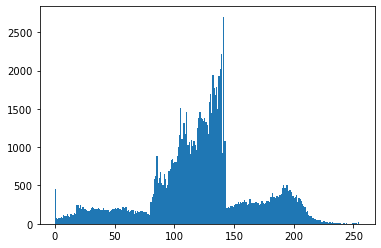

In [6]:
img = plt.imread("C:/Users/david/Desktop/std_Davide_Di_Stefano_242682/book.jpg")[:,:,0]

print(img.shape)
data = np.ravel(img)

plt.hist(data,bins=range(min(data), max(data) + 1))

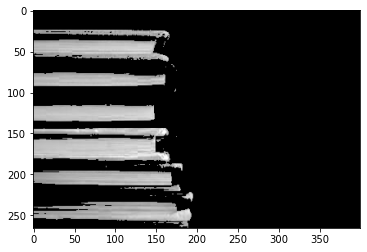

In [18]:
cond1 = np.where(img>=0, True, False)
cond2 = np.where(img<=145, True, False)

cond = np.logical_and(cond1,cond2)

new_img = np.where(cond,0,img)

plt.imshow(new_img,cmap="gray")
plt.show()

# Esercizio 2


Spiegare la differenza tra VAE e AE.
In che cosa consiste il reparameterization trick?

La struttura AE è un'architettura neurale che consiste di un encoder e di un decoder. L'encoder apprende quello che viene chiamato "spazio latente" dell'input, il decoder invece, a partire da questo spazio latente cerca di ricostruire l'input di partenza.
Il VAE, nell'ambito di generazioni di immagini, è una specializzazione dell'AE e si basa sull'inferenza variazionale, attraverso l'encoder cerchiamo di stimare i parametri della distribuzione di probabilità P(z|x), nella rappresentazione latente. Grazie all'encoder apprendiamo i parametri di tale distribuzione, cioé i valori di media e varianza, e campioniamo z secondo una distribuzione normale. Viene inoltre effettuato il parametrization trick per evitare il fenomeno della "spezzata del gradiente" durante l'apprendimento. Esso consiste nel NON campionare direttamente z, ma campionare, secondo una normale standard, un'epsilon. Il decoder stima i parametri della distribuzione di probabilità P(x|z).

In seguito al parametrization trick in particolare abbiamo che z = mu + sigma * epsilon, dove mu è la media e sigma la varianza

# Esercizio 3


Adattare/semplificare la rete AlexNet

- affinché gestisca un input di immagini 128x128 modificando solo i livelli conv3*


Motivare le scelte architetturali


![](https://www.researchgate.net/profile/Nicola-Strisciuglio/publication/339756908/figure/fig5/AS:866265283457032@1583545146587/AlexNet-architecture-used-as-the-baseline-model-for-the-analysis-of-results-on-the.png)

VERSIONE BASE (SOTTO QUELLA MODIFICATA):

In [87]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

def test(net, img_size=(16, 16)):
    net.eval()
    x = torch.randn((1,64,img_size[0], img_size[1]))
    print(f'Shape layer: {x.shape}')
    y = net(x)
    params = count_parameters(net)
    print(f"Input: {x.shape}; Output: {y.shape}; N. of params: {params:,}")

In [91]:
import torch.nn as nn
W, H = 16, 16


class LRN(nn.Module):
    def __init__(self, local_size=1, alpha=1.0, beta=0.75, ACROSS_CHANNELS=False):
        super(LRN, self).__init__()
        self.ACROSS_CHANNELS = ACROSS_CHANNELS
        if self.ACROSS_CHANNELS:
            self.average=nn.AvgPool3d(kernel_size=(local_size, 1, 1), 
                    stride=1,
                    padding=(int((local_size-1.0)/2), 0, 0)) 
        else:
            self.average=nn.AvgPool2d(kernel_size=local_size,
                    stride=1,
                    padding=int((local_size-1.0)/2))
        self.alpha = alpha
        self.beta = beta
    
    
    def forward(self, x):
        if self.ACROSS_CHANNELS:
            div = x.pow(2).unsqueeze(1)
            div = self.average(div).squeeze(1)
            div = div.mul(self.alpha).add(1.0).pow(self.beta)
        else:
            div = x.pow(2)
            div = self.average(div)
            div = div.mul(self.alpha).add(1.0).pow(self.beta)
        x = x.div(div)
        return x
    
    
class AlexNet(nn.Module):
    def __init__(self, num_classes = 1000):
        super().__init__()
        self.layer1 = nn.Sequential( #input 16x16
            nn.Conv2d(in_channels=64, out_channels=192, kernel_size=8, padding=4), 
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2),
            LRN(local_size=5, alpha=1e-4, beta=0.75, ACROSS_CHANNELS=True) 
        )
        
        self.layer2 = nn.Sequential( #input 8x8
            nn.Conv2d(in_channels=192, out_channels=384, kernel_size=4, groups=2, padding=2),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2),
            LRN(local_size=5, alpha=1e-4, beta=0.75, ACROSS_CHANNELS=True) 
        )
        
        self.layer3_1 = nn.Sequential( #input 4x4
            nn.Conv2d(in_channels=384, out_channels=256, padding=1, kernel_size=3),
            nn.ReLU(inplace=True)
        )
        self.layer3_2 = nn.Sequential( #input 4x4
            nn.Conv2d(in_channels=256, out_channels=256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True)
        )
        
        self.layer3_3 = nn.Sequential( #input 4x4
            nn.Conv2d(in_channels=256, out_channels=256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
        )
        
        self.layer4 = nn.Sequential( #input 4096
            nn.Linear(in_features=4096, out_features=4096),
            nn.ReLU(inplace=True),
            nn.Dropout()
        )
        self.layer5 = nn.Sequential( #input 4096
            nn.Linear(in_features=4096, out_features=4096),
            nn.ReLU(inplace=True),
            nn.Dropout()
        )
        
        self.layer6 = nn.Linear(in_features=4096, out_features=num_classes)
        
    def forward(self, x):
        x = self.layer1(x)
        print(f'Shape layer: {x.shape}')
        x = self.layer2(x)
        print(f'Shape layer: {x.shape}')
        x = self.layer3_1(x)
        print(f'Shape layer: {x.shape}')
        x = self.layer3_2(x)
        print(f'Shape layer: {x.shape}')
        x = self.layer3_3(x)
        print(f'Shape layer: {x.shape}')
        
        x = x.view(-1, 4*4*256) #flattenizzazione
        print(f'Shape layer: {x.shape}')
        x = self.layer6(self.layer5(self.layer4(x)))
        print(f'Shape layer: {x.shape}')
        
        return x
    

alexnet = AlexNet()
test(alexnet, (W, H))

Shape layer: torch.Size([1, 64, 16, 16])
Shape layer: torch.Size([1, 192, 8, 8])
Shape layer: torch.Size([1, 384, 4, 4])
Shape layer: torch.Size([1, 256, 4, 4])
Shape layer: torch.Size([1, 256, 4, 4])
Shape layer: torch.Size([1, 256, 4, 4])
Shape layer: torch.Size([1, 4096])
Shape layer: torch.Size([1, 1000])
Input: torch.Size([1, 64, 16, 16]); Output: torch.Size([1, 1000]); N. of params: 41,101,608


MODIFICA PER IMMAGINI 128x128 modificando solo conv3, introducendo stride in conv3_1

In [97]:
import torch.nn as nn
W, H = 128, 128


class LRN(nn.Module):
    def __init__(self, local_size=1, alpha=1.0, beta=0.75, ACROSS_CHANNELS=False):
        super(LRN, self).__init__()
        self.ACROSS_CHANNELS = ACROSS_CHANNELS
        if self.ACROSS_CHANNELS:
            self.average=nn.AvgPool3d(kernel_size=(local_size, 1, 1), 
                    stride=1,
                    padding=(int((local_size-1.0)/2), 0, 0)) 
        else:
            self.average=nn.AvgPool2d(kernel_size=local_size,
                    stride=1,
                    padding=int((local_size-1.0)/2))
        self.alpha = alpha
        self.beta = beta
    
    
    def forward(self, x):
        if self.ACROSS_CHANNELS:
            div = x.pow(2).unsqueeze(1)
            div = self.average(div).squeeze(1)
            div = div.mul(self.alpha).add(1.0).pow(self.beta)
        else:
            div = x.pow(2)
            div = self.average(div)
            div = div.mul(self.alpha).add(1.0).pow(self.beta)
        x = x.div(div)
        return x
    
    
class AlexNet(nn.Module):
    def __init__(self, num_classes = 1000):
        super().__init__()
        self.layer1 = nn.Sequential( #input 128x128
            nn.Conv2d(in_channels=64, out_channels=192, kernel_size=8, padding=4), 
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2),
            LRN(local_size=5, alpha=1e-4, beta=0.75, ACROSS_CHANNELS=True) 
        )
        
        self.layer2 = nn.Sequential( #input 8x8
            nn.Conv2d(in_channels=192, out_channels=384, kernel_size=4, groups=2, padding=2),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2),
            LRN(local_size=5, alpha=1e-4, beta=0.75, ACROSS_CHANNELS=True) 
        )
        
        self.layer3_1 = nn.Sequential( #input 4x4
            nn.Conv2d(in_channels=384, out_channels=256, padding=1, kernel_size=3, stride=8), #introduco lo stride in conv3_1
            nn.ReLU(inplace=True)
        )
        self.layer3_2 = nn.Sequential( #input 4x4
            nn.Conv2d(in_channels=256, out_channels=256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True)
        )
        
        self.layer3_3 = nn.Sequential( #input 4x4
            nn.Conv2d(in_channels=256, out_channels=256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
        )
        
        self.layer4 = nn.Sequential( #input 4096
            nn.Linear(in_features=4096, out_features=4096),
            nn.ReLU(inplace=True),
            nn.Dropout()
        )
        self.layer5 = nn.Sequential( #input 4096
            nn.Linear(in_features=4096, out_features=4096),
            nn.ReLU(inplace=True),
            nn.Dropout()
        )
        
        self.layer6 = nn.Linear(in_features=4096, out_features=num_classes)
        
    def forward(self, x):
        x = self.layer1(x)
        print(f'Shape layer: {x.shape}')
        x = self.layer2(x)
        print(f'Shape layer: {x.shape}')
        x = self.layer3_1(x)
        print(f'Shape layer: {x.shape}')
        x = self.layer3_2(x)
        print(f'Shape layer: {x.shape}')
        x = self.layer3_3(x)
        print(f'Shape layer: {x.shape}')
        
        x = x.view(-1, 4*4*256) #flattenizzazione
        print(f'Shape layer: {x.shape}')
        x = self.layer6(self.layer5(self.layer4(x)))
        print(f'Shape layer: {x.shape}')
        
        return x
    

alexnet = AlexNet()
test(alexnet, (W, H))

Shape layer: torch.Size([1, 64, 128, 128])
Shape layer: torch.Size([1, 192, 64, 64])
Shape layer: torch.Size([1, 384, 32, 32])
Shape layer: torch.Size([1, 256, 4, 4])
Shape layer: torch.Size([1, 256, 4, 4])
Shape layer: torch.Size([1, 256, 4, 4])
Shape layer: torch.Size([1, 4096])
Shape layer: torch.Size([1, 1000])
Input: torch.Size([1, 64, 128, 128]); Output: torch.Size([1, 1000]); N. of params: 41,101,608


# Esercizio 4


Dato il seguente frammento di codice


    conv1 = torch.nn.Conv2d(3, 20, kernel_size=5, padding=1, stride=2)
    conv2 = torch.nn.Conv2d(10, 30, kernel_size=(3, 6), padding=1, stride=(3, 2))

    model = lambda x: conv2(conv1(x))

Indicare giustificando la risposta qual'è il risultato per un'immagine 1x3x600x600 illustrandolo con un esempio. 

Tenendo presente la formula che ci permette di stabilire la size dell'output in seguito alla convoluzione:

$
output = \frac {input + 2*padding - dilation*(kernel-1)-1} {stride} + 1
$

In [34]:
conv1 = torch.nn.Conv2d(3, 20, kernel_size=5, padding=1, stride=2)
conv2 = torch.nn.Conv2d(20, 30, kernel_size=(3, 6), padding=1, stride=(3, 2))

model = lambda x: conv2(conv1(x))

In [35]:
x = torch.Tensor(np.full((1,3,600,600),1))


print(x.shape)
print(conv1(x).shape)
print(conv2(conv1(x)).shape)

torch.Size([1, 3, 600, 600])
torch.Size([1, 20, 299, 299])
torch.Size([1, 30, 100, 148])


# Esercizio 5


Data un'immagine a scelta, mostrare gli effetti della dilated convolution

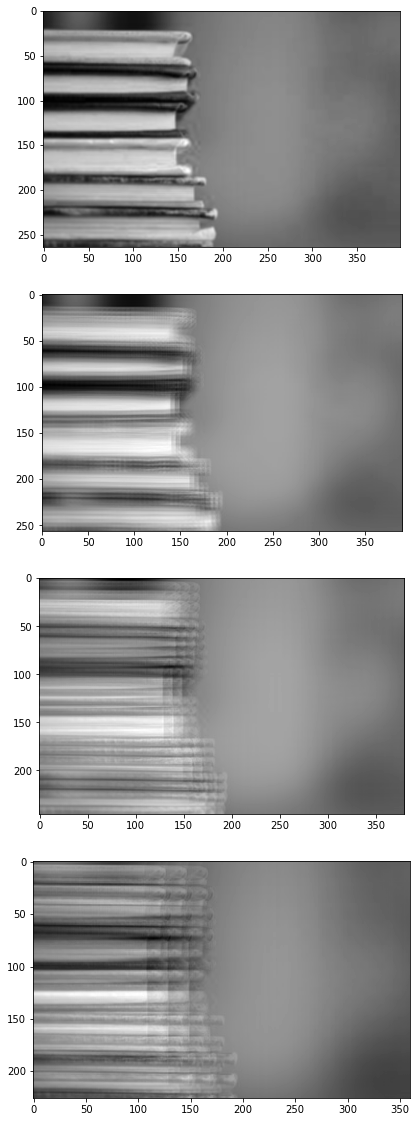

In [27]:
conv1 = nn.Conv2d(1,1,kernel_size=3,dilation=1)
conv2 = nn.Conv2d(1,1,kernel_size=3,dilation=5)
conv3 = nn.Conv2d(1,1,kernel_size=3,dilation=10)
conv4 = nn.Conv2d(1,1,kernel_size=3,dilation=20)
nn.init.ones_(conv1.weight)
nn.init.ones_(conv2.weight)
nn.init.ones_(conv3.weight)
nn.init.ones_(conv4.weight)

im = torchvision.io.read_image("C:/Users/david/Desktop/std_Davide_Di_Stefano_242682/book.jpg")/255
im = im[0,:,:].unsqueeze(0)

#print(im.shape)

plt.figure(figsize=(20,20))
plt.subplot(4,1,1)
plt.imshow(conv1(im).permute(1,2,0).detach().numpy(),cmap="gray")

plt.subplot(4,1,2)
plt.imshow(conv2(im).permute(1,2,0).detach().numpy(),cmap="gray")

plt.subplot(4,1,3)
plt.imshow(conv3(im).permute(1,2,0).detach().numpy(),cmap="gray")

plt.subplot(4,1,4)
plt.imshow(conv4(im).permute(1,2,0).detach().numpy(),cmap="gray")


plt.show()